## Part 2 of 2

- for more info refer to capstone presentation slides: https://goo.gl/ghPyUY

In [596]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [597]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import pickle

In [598]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as esw
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import sys, os, re, csv, codecs

In [599]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.multioutput import ClassifierChain
from scipy import sparse

In [600]:
# Keras
from keras.layers import (Dense, Input, Bidirectional, Activation, Dropout, Embedding, Flatten, Lambda,
                          Conv2D, MaxPool2D, concatenate, K, Reshape, LSTM, GRU)
    
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.preprocessing import text, sequence
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers
import tensorflow as tf
from keras.models import model_from_json

In [492]:
pred_dirty = pd.read_csv('./datasets/test_predictions.csv', index_col=0)
new_train = pd.read_csv('./datasets/train_predictions.csv', index_col=0)

In [500]:
X = new_train[((new_train['predicted_dirty'] == 1)|(new_train['actual_dirty'] == 1))]
X_train = X['clean_text'].values

In [501]:
y_train = X.loc[:, ['toxic' ,'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_test = pred_dirty.loc[pred_dirty[pred_dirty['predicted_dirty'] == 1].index,'clean_text'].values

In [502]:
X_train.shape, y_train.shape, X_test.shape

((17701,), (17701, 6), (34694,))

## Bi-directional LSTM w GloVe

In [496]:
X['word_count'].mean()

53.601265465227954

In [497]:
# embedding info
max_features = 300000
maxlen = 200
embed_size = 300

In [498]:
# tokenize
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
# get word vectors
EMBEDDING_FILE = '/Users/Han/Downloads/Data/word_embeddings/glove.42B.300d.txt'

embeddings_index = {}
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
word_index = tokenizer.word_index

num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i >= max_features: 
        continue
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

In [ ]:
# build model
def get_model():
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(num_words, embed_size, weights=[embedding_matrix], input_length=maxlen)(inp)
    x = Dropout(0.5)(x)    

    x = Bidirectional(LSTM(300, return_sequences=True), merge_mode='sum')(x)
    x = Dropout(0.2)(x)
    x = Reshape((200, 300, 1))(x)

    x = Conv2D(100, kernel_size=(5,5), padding='valid', kernel_initializer='glorot_uniform')(x)
    x = MaxPool2D(pool_size=(5,5))(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(6, activation = "sigmoid",  kernel_regularizer=regularizers.l2(.00001))(x)
    
    parallel_model = Model(inputs = inp, outputs = x)
    parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return parallel_model

# get model
model = get_model()

In [ ]:
# fit parameters
batch_size = 32
epochs = 5

# get test/train and ROC AUC callback
[X_tra, X_val, y_tra, y_val] = train_test_split(x_train, y_train, test_size=.1, random_state=233)

In [ ]:
# fit
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)
y_pred = model.predict(x_test, verbose=1)

#### at this point, I switched over to GCP Datalab to run my DL models. Below I will load the trained models and predicted values

In [ ]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
# load json and create model
json_file = open('./Models/bilstm_dirtyonly.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
# load weights into new model
loaded_model.load_weights('./Models/bilstm_dirtyonly.h5')
print("Loaded model from disk")

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
y_pred = loaded_model.predict(x_test, verbose=1)

#### Preparing submission file

In [69]:
dirty_labels = pd.read_csv('./Models/bilstm_dirtyonly.csv', index_col=0)
test_labels = pd.read_csv('./Datasets/all/test_labels.csv')

In [70]:
# checking if datasets match up
print(pred_dirty[pred_dirty['predicted_dirty'] == 1].shape, dirty_labels.shape)
print(np.any(pred_dirty['id'] != test_labels['id']))

(34694, 16) (34694, 6)
False


In [73]:
# removing previous inputs
test_labels.loc[:,['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = np.NaN
dirty_labels.columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [74]:
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    test_labels.loc[pred_dirty['predicted_dirty'] == 1, column] = dirty_labels[column].values

In [82]:
submission = test_labels.fillna(0.0)
submission.set_index('id', inplace=True)
submission.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.978086,0.647733,0.985769,0.250023,0.830881,0.913865
0000247867823ef7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00013b17ad220c46,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00017563c3f7919a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00017695ad8997eb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
submission.to_csv('./submissions/2layer_nbsvm-bilstm.csv')

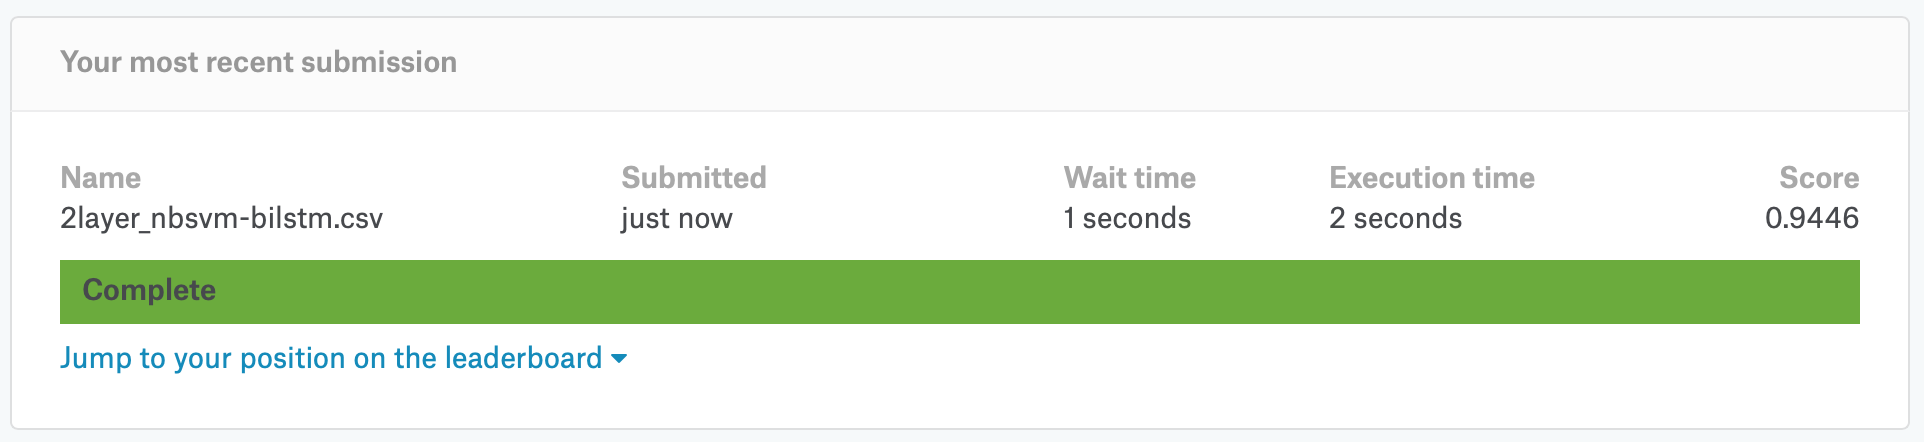

In [157]:
# 2layer_nbsvm-bilstm
get_ranking(0.9446)

Rank:        4011 (4011)/4551
Percentile:  88.13%


#### Results are poor - only at the 88th percentile. Problem might be due to the 2-step approach, where the NBSVM step is unable to classify clean vs dirty comments well (e.g. when there are extreme comments like those in the severe toxic, threat, and identity hate labels, the model might miss out on 'milder' toxic comments).

# SINGLE STEP APPROACH
## NBSVM w TFIDF (word & char)

In [602]:
# same code and approach as the previous notebook
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs, solver='liblinear').fit(x_nb, y)
        
#         self._clf = LinearSVC(C=self.C, class_weight=None, dual=self.dual, fit_intercept=True,
#                               loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', 
#                               random_state=0, tol=0.0001,verbose=0).fit(x_nb, y)
        return self

In [601]:
class ModelClassTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        #self.column_name = column_name
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X, **transform_params):
        return np.array(self.model.predict_proba(X)[:,1:])

In [603]:
get_word_proba = Pipeline([('tfidf_word', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, strip_accents='unicode', max_features= 30000, min_df=5, lowercase=False)), 
                     ('nbsvm_word', ModelClassTransformer(NbSvmClassifier(C=0.5, dual=True)))])

get_char_proba = Pipeline([('tfidf_char', TfidfVectorizer(ngram_range=(2,4), analyzer='char', sublinear_tf=True, strip_accents='unicode', max_features= 30000, lowercase=False)), 
                     ('nbsvm_char', ModelClassTransformer(NbSvmClassifier(C=1, dual=True)))])

In [604]:
def select_textfeatures(X):
    return X.loc[:, 'clean_text']

def select_metafeatures(X):
    return X.loc[:, meta_features]

meta_features = ['char_count', 'word_count', 'unique_word_count', 'unique_ratio', 'punc', 'caps', 'neg', 'neu',
       'pos', 'compound', 'profanity_count']

In [605]:
compile_text_probas = Pipeline([('get_text', FunctionTransformer(select_textfeatures, validate=False)), 
                  ('get_probas', FeatureUnion([
                                                ('word_proba', get_word_proba), 
                                                ('char_proba', get_char_proba)]))])

In [606]:
final_score_xg = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

In [607]:
meta_features = ['char_count', 'word_count', 'unique_word_count', 'unique_ratio', 
                 'punc', 'caps', 'neg', 'neu', 'pos', 'compound', 'profanity_count']

In [608]:
# pipeline throwing errors due to a NA values in clean_text
new_train['clean_text'].fillna(' ', inplace=True)
pred_dirty['clean_text'].fillna(' ', inplace=True)

In [274]:
# column by column independent prediction 
predictions = {}

for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    final_score_xg.fit(new_train, new_train[label])
    predictions[label] = final_score_xg.predict_proba(pred_dirty)[:,1:]
    print(label, final_score_xg.score(new_train, new_train[label]))

toxic 0.9695558716809445
severe_toxic 0.9932193192998728
obscene 0.9849972739407536
threat 0.9988531750756716
insult 0.9784923325666944
identity_hate 0.9947233519875165


In [280]:
test_labels.loc[:,['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = np.NaN

In [296]:
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    test_labels[column] = predictions[column]

In [298]:
submission = test_labels.set_index('id')
submission.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.996397,0.270653,0.984369,0.053288,0.949762,0.307709
0000247867823ef7,0.000508,0.000029,0.000079,0.000027,0.000136,0.000034
00013b17ad220c46,0.001158,0.000033,0.000085,0.000027,0.000091,0.000034
00017563c3f7919a,0.000221,0.000036,0.000056,0.000027,0.000097,0.000034
00017695ad8997eb,0.002164,0.000034,0.000137,0.000027,0.000102,0.000037


In [300]:
submission.to_csv('./submissions/1layer_nbsvm.csv')

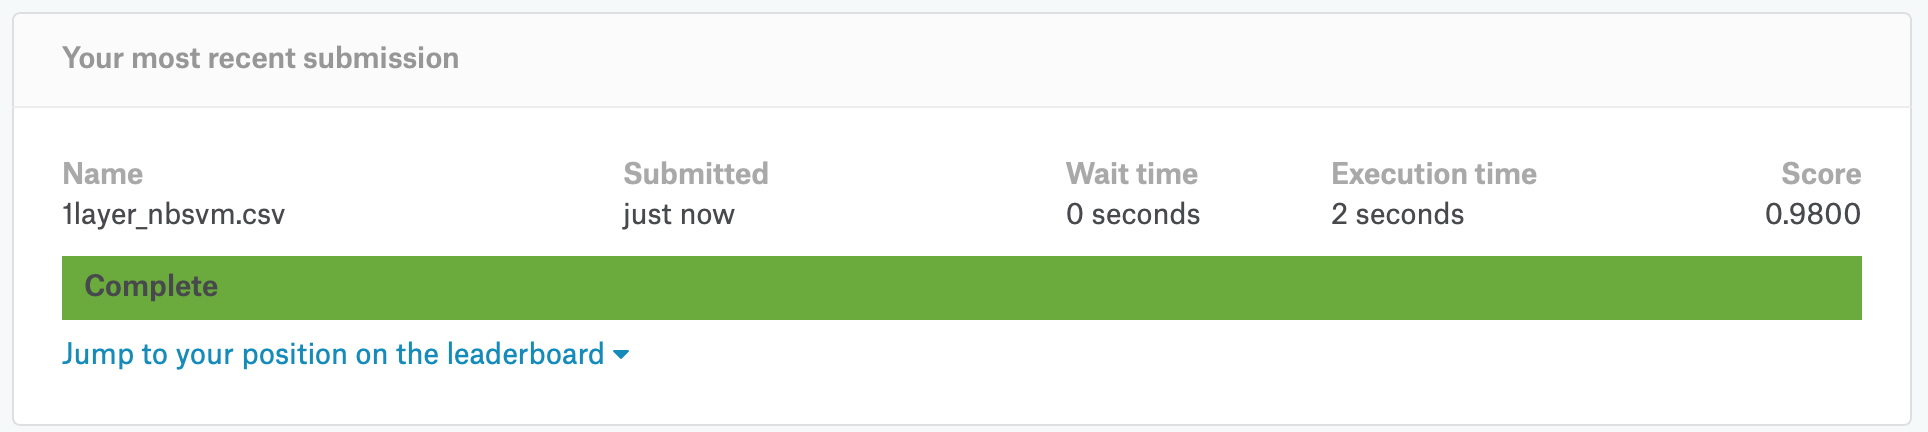

In [301]:
# 1layer_nbsvm
get_ranking(0.9800)

Rank:        2433 (2443)/4551
Percentile:  53.46%


## Bi-directional LSTM w GloVe

In [ ]:
# same code as above

In [467]:
pred_labels = pd.read_csv('./Models/bilstm_all.csv', index_col=0)
test_labels = pd.read_csv('./Datasets/all/test_labels.csv')

In [468]:
pred_labels.shape, test_labels.shape

((153164, 6), (153164, 7))

In [471]:
test_labels.loc[:,['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] = np.NaN
pred_labels.columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [474]:
test_labels['toxic'] = pred_labels['toxic']

In [476]:
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    test_labels[column] = pred_labels[column]

In [479]:
submission = test_labels.set_index('id')
submission.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.985893,2.095787e-01,0.984776,0.062410,0.755092,0.345615
0000247867823ef7,0.000200,9.057098e-07,0.000023,0.000014,0.000048,0.000002
00013b17ad220c46,0.010966,2.725433e-04,0.002568,0.000556,0.002105,0.000753
00017563c3f7919a,0.000472,1.748717e-06,0.000078,0.000042,0.000032,0.000003
00017695ad8997eb,0.001815,1.721748e-05,0.000168,0.000072,0.000243,0.000037


In [480]:
submission.to_csv('./submissions/1layer_biLSTM.csv')

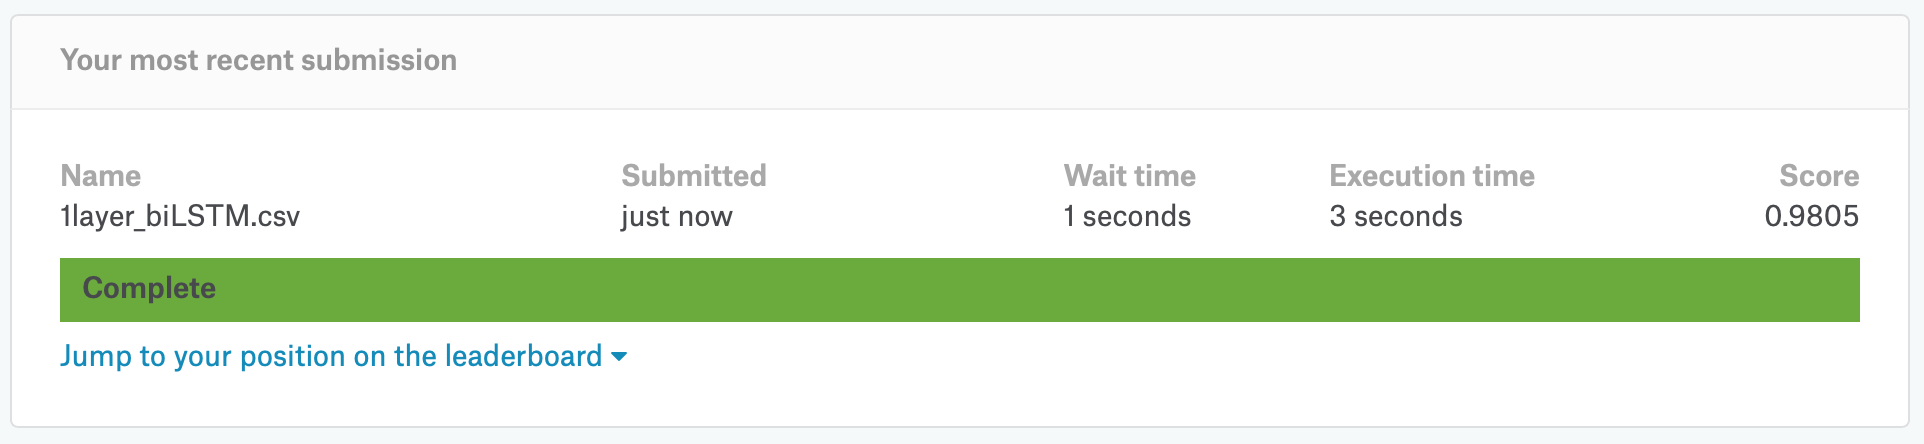

In [481]:
# 1layer_nbsvm
get_ranking(0.9805)

Rank:        2379 (2396)/4551
Percentile:  52.27%


## Combine

In [509]:
biLSTM = pd.read_csv('./submissions/1layer_biLSTM.csv')
nbsvm = pd.read_csv('./submissions/1layer_nbsvm.csv')

In [563]:
conf_proba = (biLSTM.iloc[:,1:] * nbsvm.iloc[:,1:])\
                / ((biLSTM.iloc[:,1:] * nbsvm.iloc[:,1:]) + ((1 - biLSTM.iloc[:,1:])*(1-nbsvm.iloc[:,1:])))
conf_proba['id'] = biLSTM['id']
conf_proba.set_index('id', inplace=True)
conf_proba.to_csv('./submissions/2conf.csv')

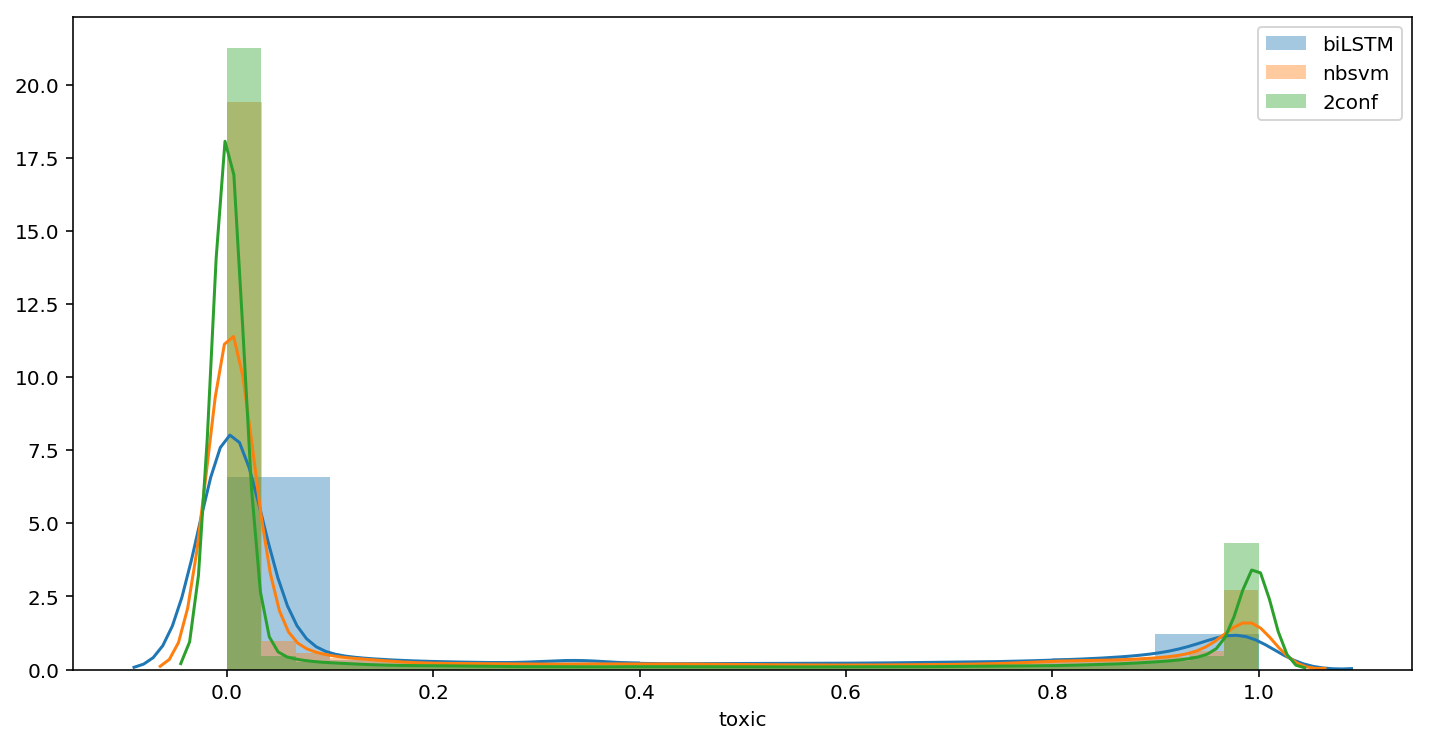

In [568]:
target= 'toxic'

plt.figure(figsize=(12,6))
sns.distplot(biLSTM[target], bins=10, label='biLSTM')
sns.distplot(nbsvm[target], bins=30, label='nbsvm')

sns.distplot(conf_proba[target], bins=30, label='2conf')

plt.legend()
plt.show()

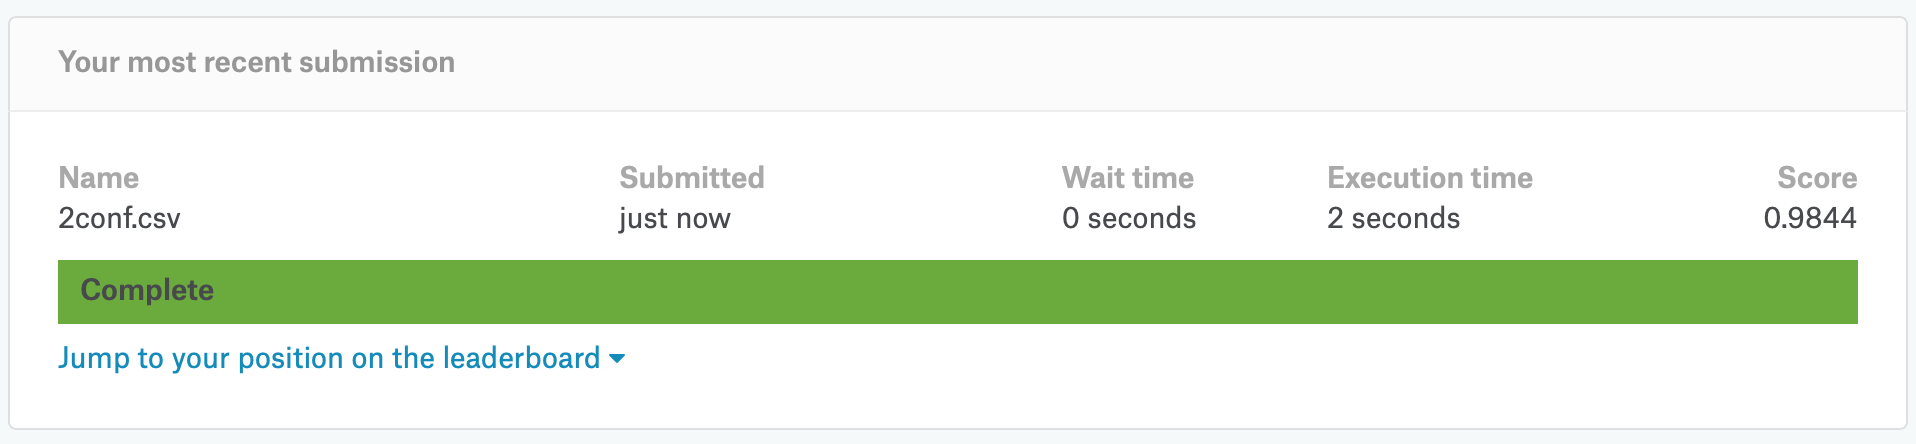

In [566]:
# 1layer_nbsvm
get_ranking(0.9844)

Rank:        1657 (1682)/4551
Percentile:  36.41%


In [1]:
# avg_proba = (biLSTM.iloc[:,1:] + nbsvm.iloc[:,1:])/2
# avg_proba['id'] = biLSTM['id']
# avg_proba.set_index('id', inplace=True)
# avg_proba.to_csv('./submissions/2avg.csv')

# target= 'toxic'

# plt.figure(figsize=(12,6))
# sns.distplot(biLSTM[target], bins=30, label='biLSTM')
# sns.distplot(nbsvm[target], bins=30, label='nbsvm')
# sns.distplot(avg_proba[target], bins=30, label='2avg')
# plt.legend()
# plt.show()

# ![Screenshot%202018-11-22%2002.08.23.png](attachment:Screenshot%202018-11-22%2002.08.23.png)

## ELMo 
(final extra model - just wanted to test out the deep word-embeddings)

In [304]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

In [ ]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2")

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [ ]:
# ### test first
# train_text = np.asarray(clean_text_train[:1000])
# train_label = np.asarray(rtrain.loc[:999, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']])

# test_text = np.asarray(clean_text_train[200:700])
# test_label = np.asarray(rtrain.loc[200:699, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']])

In [ ]:
train_text = np.asarray(clean_text_train)
train_label = np.asarray(rtrain.loc[:, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']])

test_text = np.asarray(clean_text_test)

In [ ]:
train_text.shape, train_label.shape, test_text.shape, test_label.shape

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
saver = tf.train.Saver()

In [ ]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(1024,))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(6, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(train_text, train_label, epochs=1, batch_size=16)
    model.save_weights('./elmo_all.h5')
    saver.save(sess, 'elmo_model')

In [ ]:
# !gsutil cp 'elmo_all.h5' gs://sound-bit-218505_toxic_models

In [ ]:
y_pred = model.predict(x_test, verbose=1)

## Saving and exporting models

In [619]:
new_train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean_text', 'char_count', 'word_count',
       'unique_word_count', 'unique_word_ratio', 'punc', 'caps',
       'profanity_count', 'neg', 'neu', 'pos', 'compound', 'predicted_dirty',
       'predicted_dirty_proba', 'actual_dirty'],
      dtype='object')

In [620]:
toxic_pipeline = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

toxic_pipeline.fit(new_train, new_train['toxic'])
pickle.dump(toxic_pipeline, open('1layer_nbsvm_toxic.sav', 'wb'))

/Users/Han/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [621]:
severe_toxic_pipeline = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

severe_toxic_pipeline.fit(new_train, new_train['severe_toxic'])
pickle.dump(severe_toxic_pipeline, open('1layer_nbsvm_severe_toxic.sav', 'wb'))

In [622]:
obscene_pipeline = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

obscene_pipeline.fit(new_train, new_train['obscene'])
pickle.dump(obscene_pipeline, open('1layer_nbsvm_obscene.sav', 'wb'))

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1a6ebd5c18>>
Traceback (most recent call last):
  File "/Users/Han/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1398, in __del__
    self._session._session, self._handle, status)
  File "/Users/Han/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140436740056336


In [624]:
threat_pipeline = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

threat_pipeline.fit(new_train, new_train['threat'])
pickle.dump(threat_pipeline, open('1layer_nbsvm_threat.sav', 'wb'))

In [625]:
insult_pipeline = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

insult_pipeline.fit(new_train, new_train['insult'])
pickle.dump(insult_pipeline, open('1layer_nbsvm_insult.sav', 'wb'))

In [626]:
identity_hate_pipeline = \
Pipeline([('Xtrain_all', FeatureUnion([('part1', compile_text_probas), 
                                       ('part2', FunctionTransformer(select_metafeatures, validate=False))])),
         ('xgb', XGBClassifier(n_jobs=-1, random_state=42))])

identity_hate_pipeline.fit(new_train, new_train['identity_hate'])
pickle.dump(identity_hate_pipeline, open('1layer_nbsvm_identity_hate.sav', 'wb'))

## For fun / scrap code

In [84]:
rankings = pd.read_csv('/Users/Han/Downloads/jigsaw-toxic-comment-classification-challenge-publicleaderboard.csv')
scores = rankings.groupby('TeamName').max().sort_values(by='Score', ascending=False)

In [85]:
len(rankings), len(scores)

(26400, 4551)

In [86]:
scores.reset_index(inplace=True)
scores.loc[0,'Score'] = 0.7729
scores.loc[1,'Score'] = 0.9875
scores.drop(2, inplace=True)

In [90]:
scores = scores.sort_values(by='Score', ascending=False).reset_index(drop=True)
# scores.index = scores.index+1
leaderboard = scores['Score'].tolist()
len(leaderboard)

4550

In [155]:
def get_ranking(score):
    leaderboard = scores['Score'].tolist()
    leaderboard.append(score)
    leaderboard.sort(reverse=True)
    first_pos = leaderboard.index(score) +1
    leaderboard.sort()
    last_pos = len(leaderboard) - leaderboard.index(score)
    print(f'Rank:        {first_pos} ({last_pos})/{len(leaderboard)}\nPercentile:  {round((first_pos/len(leaderboard))*100,2)}%')

In [156]:
# 2layer_nbsvm-bilstm
get_ranking(0.9446)

Rank:        4011 (4011)/4551
Percentile:  88.13%


In [704]:
# eda = new_train[['char_count', 'word_count', 'unique_word_count', 'unique_word_ratio',
#        'punc', 'caps', 'profanity_count', 'neg', 'neu', 'pos', 'compound', 'actual_dirty']]

# eda = new_train.groupby('actual_dirty').mean()
# eda = eda[['char_count', 'word_count', 'unique_word_count', 'unique_word_ratio',
#        'punc', 'caps', 'profanity_count', 'neg', 'neu', 'pos', 'compound']]

# eda.reset_index(inplace=True)

# for column in ['char_count', 'word_count', 'unique_word_count', 'unique_word_ratio',
#        'punc', 'caps', 'profanity_count', 'neg', 'neu', 'pos', 'compound']:
#     plt.figure()
#     sns.barplot(x='actual_dirty', y=column, data=eda, palette='coolwarm')
#     plt.title(column)